# Table of Contets
0. [Preprocess](#0)

1. [Classical machine learning models](#1)
    1.1 [Logistic Regression](#1-1)  
    1.2 [SVM](#1-2)
    1.3 [Tree Ensemble](#1-3)
2. [Deeplearning models](#2)
    2.1 [Fully Connected Network](#2-1)
    2.2 [Convolutional Network](#2-2)
    2.3 [Recurrent Network](#2-3)
3. [Visualization](#3)
4. [Summary and Conclusion](#4)


# Preprocess <a class="anchor" id="0"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
data_path = "./data/splice.data"

In [4]:
df = pd.read_csv(data_path, header=None, names=["class", "name", "seq"])
len(df)

3190

In [5]:
# blank handling
df['class'] = df['class'].apply(lambda x: x.strip())
df['name'] = df['name'].apply(lambda x: x.strip())
df['seq'] = df['seq'].apply(lambda x: x.strip())

In [6]:
# remove redundant rows
drop_index = list()
for seq in df['seq'].unique():
    rows = df[df['seq'] == seq]
    if len(rows) > 1:
        if len(rows["class"].unique()) != 1:
            drop_index += list(rows.index)
        else:
            drop_index += list(rows.index[1:])
len(drop_index)

186

In [7]:
df.drop(index=drop_index, inplace=True)
len(df)

3004

In [8]:
# check no more redundant row
max(df['seq'].value_counts())

1

In [9]:
# target label
y = df['class'].values

In [10]:
# input handling
count_dict= defaultdict(lambda:0)
seqs = df['seq'].values
for seq in seqs:
    for b in seq:
        count_dict[b]+=1
# base count
count_dict

defaultdict(<function __main__.<lambda>()>,
            {'C': 47093,
             'A': 42134,
             'G': 47315,
             'T': 43638,
             'N': 56,
             'D': 2,
             'R': 1,
             'S': 1})

In [11]:
# build base dictionary
base_dict = {k:v for k, v in enumerate(count_dict.keys())}
base_dict_inv = {v:k for k,v in base_dict.items()}
base_dict_inv

{'C': 0, 'A': 1, 'G': 2, 'T': 3, 'N': 4, 'D': 5, 'R': 6, 'S': 7}

In [12]:
# encode 
def encode_seq(seq):
    return [base_dict_inv[b] for b in seq]
X = np.array(list(map(encode_seq, seqs)))
X_onehot = np.array([np.array([np.eye(len(base_dict), dtype=np.uint8)[i] for i in row])for row in X])
X_onehot_unfold = X_onehot.reshape([X_onehot.shape[0], -1])
X.shape , X_onehot.shape , X_onehot_unfold.shape

((3004, 60), (3004, 60, 8), (3004, 480))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# use one-hot input
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2)
len(X_train), len(X_test)

(2403, 601)

# Classical machine learning models <a class="anchor" id="1"></a>


In [15]:
def make_input_classic(X_):
    return X_.reshape(X_.shape[0], -1)

## Logistic regression <a class="anchor" id="1-1"></a>

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [17]:
logreg = LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(logreg,grid, cv=10, n_jobs=5)

In [18]:
%%time
# unfold and fit
logreg_cv.fit(make_input_classic(X_train) ,y_train)

CPU times: user 381 ms, sys: 39.3 ms, total: 421 ms
Wall time: 20 s


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1'}
accuracy : 0.9550561797752809


In [20]:
logreg_best=LogisticRegression(**logreg_cv.best_params_)
logreg_best.fit(make_input_classic(X_train) ,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
print("train score: %.4f" % logreg_best.score(make_input_classic(X_train), y_train))
print("test  score: %.4f" % logreg_best.score(make_input_classic(X_test), y_test))

train score: 0.9646
test  score: 0.9667


## SVM <a class="anchor" id="1-2"></a>

In [22]:
from sklearn.svm import SVC, LinearSVC

In [23]:
svm = SVC()
grid = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}
svm_cv = GridSearchCV(svm, grid, cv=10, n_jobs=5)

In [24]:
%%time
# unfold and fit
svm_cv.fit(make_input_classic(X_train) ,y_train)

CPU times: user 4.73 s, sys: 197 ms, total: 4.93 s
Wall time: 22min 46s


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'kernel': ('linear', 'rbf'), 'C': (1, 0.25, 0.5, 0.75), 'gamma': (1, 2, 3, 'auto'), 'decision_function_shape': ('ovo', 'ovr'), 'shrinking': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}
accuracy : 0.9571369121930919


In [26]:
svm_best=SVC(**svm_cv.best_params_)
svm_best.fit(make_input_classic(X_train) ,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
print("train score: %.4f" % svm_best.score(make_input_classic(X_train), y_train))
print("test  score: %.4f" % svm_best.score(make_input_classic(X_test), y_test))

train score: 0.9655
test  score: 0.9517


## Tree Ensemble <a class="anchor" id="1-3"></a>

In [28]:
from xgboost import XGBClassifier

In [29]:
xgb_model = XGBClassifier()

In [30]:
grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softmax'],
              "num_class":[len(df['class'].unique())],
              'learning_rate': [0.02], #so called `eta` value
              'max_depth': [8],
              'min_child_weight': [1,0],
              'silent': [1],
              'gamma':[0.5, 1.0],
              'subsample': [0.8, 1.0],
              'colsample_bytree': [0.8, 1.0],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'tree_method': ['gpu_hist'],
              'missing':[-999]}

In [31]:
xgb_cv = GridSearchCV(xgb_model, grid, n_jobs=5, 
                   cv=5, 
                   verbose=2, refit=True)

In [32]:
%%time
xgb_cv.fit(make_input_classic(X_train) ,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 18.8min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed: 45.7min finished


CPU times: user 49.2 s, sys: 2.32 s, total: 51.5 s
Wall time: 45min 53s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'nthread': [4], 'objective': ['multi:softmax'], 'num_class': [3], 'learning_rate': [0.02], 'max_depth': [8], 'min_child_weight': [1, 0], 'silent': [1], 'gamma': [0.5, 1.0], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'n_estimators': [1000], 'tree_method': ['gpu_hist'], 'missing': [-999]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [33]:
print("tuned hpyerparameters :(best parameters) ",xgb_cv.best_params_)
print("accuracy :",xgb_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 1000, 'nthread': 4, 'num_class': 3, 'objective': 'multi:softmax', 'silent': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
accuracy : 0.9592176446109031


In [34]:
xgb_best=XGBClassifier(**xgb_cv.best_params_)
xgb_best.fit(make_input_classic(X_train) ,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.5, learning_rate=0.02,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=-999,
       n_estimators=1000, n_jobs=1, nthread=4, num_class=3,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.8, tree_method='gpu_hist')

In [35]:
print("train score: %.4f" % xgb_best.score(make_input_classic(X_train), y_train))
print("test  score: %.4f" % xgb_best.score(make_input_classic(X_test), y_test))

train score: 1.0000
test  score: 0.9684


# Deep Learning Models <a class="anchor" id="2"></a>


In [36]:
%load_ext autoreload
%autoreload 2

In [37]:
import tensorflow as tf
tf.enable_eager_execution()

In [38]:
idx2class = {k:v for k,v in enumerate(df['class'].unique())}

In [39]:
class2idx = {v:k for k,v in idx2class.items()}

In [40]:
y_train_idx = np.array(list(map(lambda s: class2idx[s], y_train)))
y_test_idx = np.array(list(map(lambda s: class2idx[s], y_test)))

In [41]:
# make val set
X_train_train, X_train_val, y_train_train_idx, y_train_val_idx = train_test_split(X_train, y_train_idx, test_size=0.1)
len(X_train_train), len(X_train_val), len(X_test)

(2162, 241, 601)

## Simple FCN <a class="anchor" id="2-1"></a>
### Hyperparameter tuning result:
- **L2 norm / Dropout : great improvement using both of them**


In [42]:
def make_input_fcn(X_):
    return X_.reshape([X_.shape[0], -1]).astype(np.float32)

In [43]:
from FCN import FCN

In [44]:
fcn_model = FCN((X_train.shape[1]*X_train.shape[2],), len(class2idx), device_name="gpu:0", checkpoint_directory="fcn/")

In [45]:
fcn_model.build()
fcn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  246272    
_________________________________________________________________
dense_2 (Dense)              multiple                  131328    
_________________________________________________________________
dense_3 (Dense)              multiple                  32896     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  387       
Total params: 410,883
Trainable params: 410,883
Non-trainable params: 0
_________________________________________________________________


In [46]:
fcn_model.fit(make_input_fcn(X_train_train), y_train_train_idx, make_input_fcn(X_train_val), y_train_val_idx, 30, 1, 128, saving=True,tqdm_option="normal")

GLOBAL 1: 100%|██████████| 2/2 [00:08<00:00,  4.96s/it]


[EPOCH 1 / STEP 1]
TRAIN loss     : 3.1605
TRAIN loss[l2] : 2.4537
TRAIN loss[net]: 0.7068
VAL   loss     : 2.4337
VAL   loss[l2] : 2.1452
TRAIN loss[net]: 0.2885
TRAIN acc      : 69.4727%
VAL   acc      : 91.7012%
saved step 1 in fcn/


GLOBAL 2: 100%|██████████| 2/2 [00:08<00:00,  4.97s/it]


[EPOCH 2 / STEP 2]
TRAIN loss     : 2.0573
TRAIN loss[l2] : 1.9060
TRAIN loss[net]: 0.1513
VAL   loss     : 1.8259
VAL   loss[l2] : 1.6538
TRAIN loss[net]: 0.1721
TRAIN acc      : 95.9297%
VAL   acc      : 95.0207%
saved step 2 in fcn/


GLOBAL 3: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 3 / STEP 3]
TRAIN loss     : 1.5465
TRAIN loss[l2] : 1.4606
TRAIN loss[net]: 0.0859
VAL   loss     : 1.4928
VAL   loss[l2] : 1.2607
TRAIN loss[net]: 0.2321
TRAIN acc      : 97.5948%
VAL   acc      : 92.1162%
saved step 3 in fcn/


GLOBAL 4: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 4 / STEP 4]
TRAIN loss     : 1.1806
TRAIN loss[l2] : 1.1118
TRAIN loss[net]: 0.0688
VAL   loss     : 1.1268
VAL   loss[l2] : 0.9583
TRAIN loss[net]: 0.1685
TRAIN acc      : 98.2424%
VAL   acc      : 93.3610%
saved step 4 in fcn/


GLOBAL 5: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 5 / STEP 5]
TRAIN loss     : 0.8842
TRAIN loss[l2] : 0.8443
TRAIN loss[net]: 0.0399
VAL   loss     : 0.9007
VAL   loss[l2] : 0.7267
TRAIN loss[net]: 0.1740
TRAIN acc      : 99.4450%
VAL   acc      : 92.9461%
saved step 5 in fcn/


GLOBAL 6: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 6 / STEP 6]
TRAIN loss     : 0.6675
TRAIN loss[l2] : 0.6391
TRAIN loss[net]: 0.0284
VAL   loss     : 0.7240
VAL   loss[l2] : 0.5490
TRAIN loss[net]: 0.1750
TRAIN acc      : 99.7225%
VAL   acc      : 93.7759%
saved step 6 in fcn/


GLOBAL 7: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 7 / STEP 7]
TRAIN loss     : 0.5030
TRAIN loss[l2] : 0.4821
TRAIN loss[net]: 0.0209
VAL   loss     : 0.6005
VAL   loss[l2] : 0.4132
TRAIN loss[net]: 0.1873
TRAIN acc      : 99.9075%
VAL   acc      : 93.3610%
saved step 7 in fcn/


GLOBAL 8: 100%|██████████| 2/2 [00:08<00:00,  4.97s/it]


[EPOCH 8 / STEP 8]
TRAIN loss     : 0.3779
TRAIN loss[l2] : 0.3621
TRAIN loss[net]: 0.0158
VAL   loss     : 0.4742
VAL   loss[l2] : 0.3095
TRAIN loss[net]: 0.1647
TRAIN acc      : 100.0000%
VAL   acc      : 93.7759%
saved step 8 in fcn/


GLOBAL 9: 100%|██████████| 2/2 [00:08<00:00,  4.90s/it]


[EPOCH 9 / STEP 9]
TRAIN loss     : 0.2848
TRAIN loss[l2] : 0.2707
TRAIN loss[net]: 0.0141
VAL   loss     : 0.3917
VAL   loss[l2] : 0.2310
TRAIN loss[net]: 0.1607
TRAIN acc      : 100.0000%
VAL   acc      : 93.7759%
saved step 9 in fcn/


GLOBAL 10: 100%|██████████| 2/2 [00:08<00:00,  4.89s/it]


[EPOCH 10 / STEP 10]
TRAIN loss     : 0.2147
TRAIN loss[l2] : 0.2019
TRAIN loss[net]: 0.0128
VAL   loss     : 0.3448
VAL   loss[l2] : 0.1722
TRAIN loss[net]: 0.1726
TRAIN acc      : 100.0000%
VAL   acc      : 93.3610%
saved step 10 in fcn/


GLOBAL 11: 100%|██████████| 2/2 [00:08<00:00,  4.89s/it]


[EPOCH 11 / STEP 11]
TRAIN loss     : 0.1621
TRAIN loss[l2] : 0.1507
TRAIN loss[net]: 0.0114
VAL   loss     : 0.3008
VAL   loss[l2] : 0.1288
TRAIN loss[net]: 0.1721
TRAIN acc      : 100.0000%
VAL   acc      : 93.3610%
saved step 11 in fcn/


GLOBAL 12: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 12 / STEP 12]
TRAIN loss     : 0.1229
TRAIN loss[l2] : 0.1127
TRAIN loss[net]: 0.0102
VAL   loss     : 0.2648
VAL   loss[l2] : 0.0964
TRAIN loss[net]: 0.1684
TRAIN acc      : 100.0000%
VAL   acc      : 93.3610%
saved step 12 in fcn/


GLOBAL 13: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 13 / STEP 13]
TRAIN loss     : 0.0935
TRAIN loss[l2] : 0.0846
TRAIN loss[net]: 0.0088
VAL   loss     : 0.2300
VAL   loss[l2] : 0.0726
TRAIN loss[net]: 0.1574
TRAIN acc      : 100.0000%
VAL   acc      : 93.7759%
saved step 13 in fcn/


GLOBAL 14: 100%|██████████| 2/2 [00:08<00:00,  4.93s/it]


[EPOCH 14 / STEP 14]
TRAIN loss     : 0.0723
TRAIN loss[l2] : 0.0639
TRAIN loss[net]: 0.0083
VAL   loss     : 0.2244
VAL   loss[l2] : 0.0552
TRAIN loss[net]: 0.1692
TRAIN acc      : 100.0000%
VAL   acc      : 94.6058%
saved step 14 in fcn/


GLOBAL 15: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 15 / STEP 15]
TRAIN loss     : 0.0561
TRAIN loss[l2] : 0.0489
TRAIN loss[net]: 0.0072
VAL   loss     : 0.1920
VAL   loss[l2] : 0.0425
TRAIN loss[net]: 0.1496
TRAIN acc      : 100.0000%
VAL   acc      : 93.7759%
saved step 15 in fcn/


GLOBAL 16: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 16 / STEP 16]
TRAIN loss     : 0.0441
TRAIN loss[l2] : 0.0378
TRAIN loss[net]: 0.0062
VAL   loss     : 0.1865
VAL   loss[l2] : 0.0331
TRAIN loss[net]: 0.1533
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 16 in fcn/


GLOBAL 17: 100%|██████████| 2/2 [00:08<00:00,  4.95s/it]


[EPOCH 17 / STEP 17]
TRAIN loss     : 0.0353
TRAIN loss[l2] : 0.0297
TRAIN loss[net]: 0.0056
VAL   loss     : 0.1801
VAL   loss[l2] : 0.0262
TRAIN loss[net]: 0.1539
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 17 in fcn/


GLOBAL 18: 100%|██████████| 2/2 [00:08<00:00,  4.88s/it]


[EPOCH 18 / STEP 18]
TRAIN loss     : 0.0286
TRAIN loss[l2] : 0.0236
TRAIN loss[net]: 0.0050
VAL   loss     : 0.1748
VAL   loss[l2] : 0.0210
TRAIN loss[net]: 0.1538
TRAIN acc      : 100.0000%
VAL   acc      : 94.6058%
saved step 18 in fcn/


GLOBAL 19: 100%|██████████| 2/2 [00:08<00:00,  4.97s/it]


[EPOCH 19 / STEP 19]
TRAIN loss     : 0.0237
TRAIN loss[l2] : 0.0192
TRAIN loss[net]: 0.0044
VAL   loss     : 0.1652
VAL   loss[l2] : 0.0173
TRAIN loss[net]: 0.1479
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 19 in fcn/


GLOBAL 20: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 20 / STEP 20]
TRAIN loss     : 0.0199
TRAIN loss[l2] : 0.0158
TRAIN loss[net]: 0.0040
VAL   loss     : 0.1656
VAL   loss[l2] : 0.0145
TRAIN loss[net]: 0.1512
TRAIN acc      : 100.0000%
VAL   acc      : 94.6058%
saved step 20 in fcn/


GLOBAL 21: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 21 / STEP 21]
TRAIN loss     : 0.0169
TRAIN loss[l2] : 0.0134
TRAIN loss[net]: 0.0035
VAL   loss     : 0.1651
VAL   loss[l2] : 0.0123
TRAIN loss[net]: 0.1528
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 21 in fcn/


GLOBAL 22: 100%|██████████| 2/2 [00:08<00:00,  4.88s/it]


[EPOCH 22 / STEP 22]
TRAIN loss     : 0.0147
TRAIN loss[l2] : 0.0115
TRAIN loss[net]: 0.0032
VAL   loss     : 0.1631
VAL   loss[l2] : 0.0107
TRAIN loss[net]: 0.1524
TRAIN acc      : 100.0000%
VAL   acc      : 94.6058%
saved step 22 in fcn/


GLOBAL 23: 100%|██████████| 2/2 [00:08<00:00,  4.90s/it]


[EPOCH 23 / STEP 23]
TRAIN loss     : 0.0130
TRAIN loss[l2] : 0.0100
TRAIN loss[net]: 0.0030
VAL   loss     : 0.1600
VAL   loss[l2] : 0.0094
TRAIN loss[net]: 0.1506
TRAIN acc      : 100.0000%
VAL   acc      : 94.6058%
saved step 23 in fcn/


GLOBAL 24: 100%|██████████| 2/2 [00:08<00:00,  4.90s/it]


[EPOCH 24 / STEP 24]
TRAIN loss     : 0.0116
TRAIN loss[l2] : 0.0089
TRAIN loss[net]: 0.0027
VAL   loss     : 0.1531
VAL   loss[l2] : 0.0085
TRAIN loss[net]: 0.1447
TRAIN acc      : 100.0000%
VAL   acc      : 95.0207%
saved step 24 in fcn/


GLOBAL 25: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 25 / STEP 25]
TRAIN loss     : 0.0104
TRAIN loss[l2] : 0.0080
TRAIN loss[net]: 0.0024
VAL   loss     : 0.1616
VAL   loss[l2] : 0.0075
TRAIN loss[net]: 0.1541
TRAIN acc      : 100.0000%
VAL   acc      : 94.6058%
saved step 25 in fcn/


GLOBAL 26: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 26 / STEP 26]
TRAIN loss     : 0.0095
TRAIN loss[l2] : 0.0072
TRAIN loss[net]: 0.0023
VAL   loss     : 0.1588
VAL   loss[l2] : 0.0069
TRAIN loss[net]: 0.1520
TRAIN acc      : 100.0000%
VAL   acc      : 95.0207%
saved step 26 in fcn/


GLOBAL 27: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 27 / STEP 27]
TRAIN loss     : 0.0086
TRAIN loss[l2] : 0.0066
TRAIN loss[net]: 0.0020
VAL   loss     : 0.1614
VAL   loss[l2] : 0.0062
TRAIN loss[net]: 0.1552
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 27 in fcn/


GLOBAL 28: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 28 / STEP 28]
TRAIN loss     : 0.0079
TRAIN loss[l2] : 0.0060
TRAIN loss[net]: 0.0020
VAL   loss     : 0.1538
VAL   loss[l2] : 0.0058
TRAIN loss[net]: 0.1480
TRAIN acc      : 100.0000%
VAL   acc      : 95.0207%
saved step 28 in fcn/


GLOBAL 29: 100%|██████████| 2/2 [00:08<00:00,  5.01s/it]


[EPOCH 29 / STEP 29]
TRAIN loss     : 0.0073
TRAIN loss[l2] : 0.0056
TRAIN loss[net]: 0.0017
VAL   loss     : 0.1579
VAL   loss[l2] : 0.0053
TRAIN loss[net]: 0.1526
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 29 in fcn/


GLOBAL 30: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 30 / STEP 30]
TRAIN loss     : 0.0068
TRAIN loss[l2] : 0.0051
TRAIN loss[net]: 0.0017
VAL   loss     : 0.1624
VAL   loss[l2] : 0.0050
TRAIN loss[net]: 0.1574
TRAIN acc      : 100.0000%
VAL   acc      : 94.1909%
saved step 30 in fcn/


In [71]:
fcn_model.load(24)

INFO:tensorflow:Restoring parameters from fcn/-24


In [72]:
pred  = tf.argmax(fcn_model(tf.convert_to_tensor(make_input_fcn(X_test)), False), axis=1).numpy()
sum(np.equal(y_test_idx , pred)) / len(y_test_idx)

0.9584026622296173

## CNN Based(Resnet) <a class="anchor" id="2-2"></a>
### Hyperparameter tuning result:
- Batchnormalization : disturb training and make network fall into local minima, removed.
- Kernel Size: not critical in deep layers structure.
- L2 norm / Dropout : no visible improvement using both of them. only use dropout.
- **Base Embedding & Positional Encoding: Most Dramatic improvement** for cnn

In [49]:
def make_input_cnn(X_):
    return np.argmax(X_, axis=2)

In [88]:
from resnet_embedding import ResnetEmbedding

In [89]:
resnet_model = ResnetEmbedding(X_train.shape[1:2],len(base_dict), 128, len(class2idx), device_name="gpu:0", checkpoint_directory="resnet/")

In [90]:
resnet_model.build()
resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  1024      
_________________________________________________________________
conv1d_54 (Conv1D)           multiple                  57408     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 multiple                  0         
_________________________________________________________________
convolution_block_3_4 (Convo multiple                  11456     
_________________________________________________________________
identitiy_block_3_12 (Identi multiple                  7296      
_________________________________________________________________
identitiy_block_3_13 (Identi multiple                  7296      
_________________________________________________________________
convolution_block_3_5 (Convo multiple                  33152     
__________

In [91]:
resnet_model.fit(make_input_cnn(X_train_train), y_train_train_idx, make_input_cnn(X_train_val), y_train_val_idx, 30, 1, 128, saving=True,tqdm_option="normal")

GLOBAL 1: 100%|██████████| 2/2 [00:09<00:00,  5.44s/it]


[EPOCH 1 / STEP 1]
TRAIN loss   : 1.9402
VAL   loss   : 1.0153
TRAIN acc    : 49.2137%
VAL   acc    : 53.1120%
saved step 1 in resnet/


GLOBAL 2: 100%|██████████| 2/2 [00:08<00:00,  5.28s/it]


[EPOCH 2 / STEP 2]
TRAIN loss   : 0.9968
VAL   loss   : 1.0132
TRAIN acc    : 55.5967%
VAL   acc    : 53.1120%
saved step 2 in resnet/


GLOBAL 3: 100%|██████████| 2/2 [00:08<00:00,  5.26s/it]


[EPOCH 3 / STEP 3]
TRAIN loss   : 0.9977
VAL   loss   : 1.0207
TRAIN acc    : 55.5967%
VAL   acc    : 53.1120%
saved step 3 in resnet/


GLOBAL 4: 100%|██████████| 2/2 [00:09<00:00,  5.49s/it]


[EPOCH 4 / STEP 4]
TRAIN loss   : 0.9971
VAL   loss   : 1.0187
TRAIN acc    : 55.5967%
VAL   acc    : 53.1120%
saved step 4 in resnet/


GLOBAL 5: 100%|██████████| 2/2 [00:09<00:00,  5.42s/it]


[EPOCH 5 / STEP 5]
TRAIN loss   : 0.9928
VAL   loss   : 1.0104
TRAIN acc    : 55.5967%
VAL   acc    : 53.1120%
saved step 5 in resnet/


GLOBAL 6: 100%|██████████| 2/2 [00:09<00:00,  5.40s/it]


[EPOCH 6 / STEP 6]
TRAIN loss   : 0.9759
VAL   loss   : 0.9519
TRAIN acc    : 55.5967%
VAL   acc    : 53.1120%
saved step 6 in resnet/


GLOBAL 7: 100%|██████████| 2/2 [00:09<00:00,  5.40s/it]


[EPOCH 7 / STEP 7]
TRAIN loss   : 0.7633
VAL   loss   : 0.6649
TRAIN acc    : 67.1138%
VAL   acc    : 65.5602%
saved step 7 in resnet/


GLOBAL 8: 100%|██████████| 2/2 [00:09<00:00,  5.36s/it]


[EPOCH 8 / STEP 8]
TRAIN loss   : 0.5099
VAL   loss   : 0.5525
TRAIN acc    : 78.4921%
VAL   acc    : 76.7635%
saved step 8 in resnet/


GLOBAL 9: 100%|██████████| 2/2 [00:08<00:00,  5.26s/it]


[EPOCH 9 / STEP 9]
TRAIN loss   : 0.4371
VAL   loss   : 0.2898
TRAIN acc    : 82.0999%
VAL   acc    : 88.3817%
saved step 9 in resnet/


GLOBAL 10: 100%|██████████| 2/2 [00:08<00:00,  5.22s/it]


[EPOCH 10 / STEP 10]
TRAIN loss   : 0.2714
VAL   loss   : 0.4413
TRAIN acc    : 89.8705%
VAL   acc    : 81.7427%
saved step 10 in resnet/


GLOBAL 11: 100%|██████████| 2/2 [00:09<00:00,  5.39s/it]


[EPOCH 11 / STEP 11]
TRAIN loss   : 0.2900
VAL   loss   : 0.2606
TRAIN acc    : 88.4829%
VAL   acc    : 90.4564%
saved step 11 in resnet/


GLOBAL 12: 100%|██████████| 2/2 [00:10<00:00,  5.85s/it]


[EPOCH 12 / STEP 12]
TRAIN loss   : 0.2289
VAL   loss   : 0.2073
TRAIN acc    : 92.4144%
VAL   acc    : 92.9461%
saved step 12 in resnet/


GLOBAL 13: 100%|██████████| 2/2 [00:09<00:00,  5.77s/it]


[EPOCH 13 / STEP 13]
TRAIN loss   : 0.1754
VAL   loss   : 0.1581
TRAIN acc    : 94.2183%
VAL   acc    : 93.7759%
saved step 13 in resnet/


GLOBAL 14: 100%|██████████| 2/2 [00:10<00:00,  5.82s/it]


[EPOCH 14 / STEP 14]
TRAIN loss   : 0.1427
VAL   loss   : 0.1976
TRAIN acc    : 95.7447%
VAL   acc    : 92.5311%
saved step 14 in resnet/


GLOBAL 15: 100%|██████████| 2/2 [00:09<00:00,  5.68s/it]


[EPOCH 15 / STEP 15]
TRAIN loss   : 0.1596
VAL   loss   : 0.1640
TRAIN acc    : 94.4033%
VAL   acc    : 92.9461%
saved step 15 in resnet/


GLOBAL 16: 100%|██████████| 2/2 [00:09<00:00,  5.74s/it]


[EPOCH 16 / STEP 16]
TRAIN loss   : 0.1397
VAL   loss   : 0.1166
TRAIN acc    : 95.0046%
VAL   acc    : 95.8506%
saved step 16 in resnet/


GLOBAL 17: 100%|██████████| 2/2 [00:09<00:00,  5.72s/it]


[EPOCH 17 / STEP 17]
TRAIN loss   : 0.1270
VAL   loss   : 0.1718
TRAIN acc    : 95.4672%
VAL   acc    : 94.6058%
saved step 17 in resnet/


GLOBAL 18: 100%|██████████| 2/2 [00:09<00:00,  5.64s/it]


[EPOCH 18 / STEP 18]
TRAIN loss   : 0.1102
VAL   loss   : 0.1358
TRAIN acc    : 96.4385%
VAL   acc    : 95.8506%
saved step 18 in resnet/


GLOBAL 19: 100%|██████████| 2/2 [00:09<00:00,  5.71s/it]


[EPOCH 19 / STEP 19]
TRAIN loss   : 0.1325
VAL   loss   : 0.1277
TRAIN acc    : 95.0046%
VAL   acc    : 95.0207%
saved step 19 in resnet/


GLOBAL 20: 100%|██████████| 2/2 [00:09<00:00,  5.78s/it]


[EPOCH 20 / STEP 20]
TRAIN loss   : 0.1132
VAL   loss   : 0.1482
TRAIN acc    : 96.4847%
VAL   acc    : 94.1909%
saved step 20 in resnet/


GLOBAL 21: 100%|██████████| 2/2 [00:09<00:00,  5.70s/it]


[EPOCH 21 / STEP 21]
TRAIN loss   : 0.1282
VAL   loss   : 0.1774
TRAIN acc    : 95.5134%
VAL   acc    : 92.9461%
saved step 21 in resnet/


GLOBAL 22: 100%|██████████| 2/2 [00:09<00:00,  5.72s/it]


[EPOCH 22 / STEP 22]
TRAIN loss   : 0.1074
VAL   loss   : 0.1087
TRAIN acc    : 96.6698%
VAL   acc    : 95.4357%
saved step 22 in resnet/


GLOBAL 23: 100%|██████████| 2/2 [00:09<00:00,  5.76s/it]


[EPOCH 23 / STEP 23]
TRAIN loss   : 0.0835
VAL   loss   : 0.1234
TRAIN acc    : 97.0398%
VAL   acc    : 96.2656%
saved step 23 in resnet/


GLOBAL 24: 100%|██████████| 2/2 [00:09<00:00,  5.55s/it]


[EPOCH 24 / STEP 24]
TRAIN loss   : 0.0943
VAL   loss   : 0.1989
TRAIN acc    : 97.0860%
VAL   acc    : 92.1162%
saved step 24 in resnet/


GLOBAL 25: 100%|██████████| 2/2 [00:09<00:00,  5.62s/it]


[EPOCH 25 / STEP 25]
TRAIN loss   : 0.0880
VAL   loss   : 0.1207
TRAIN acc    : 97.2710%
VAL   acc    : 96.2656%
saved step 25 in resnet/


GLOBAL 26: 100%|██████████| 2/2 [00:09<00:00,  5.66s/it]


[EPOCH 26 / STEP 26]
TRAIN loss   : 0.0828
VAL   loss   : 0.1393
TRAIN acc    : 97.5486%
VAL   acc    : 95.8506%
saved step 26 in resnet/


GLOBAL 27: 100%|██████████| 2/2 [00:09<00:00,  5.69s/it]


[EPOCH 27 / STEP 27]
TRAIN loss   : 0.0769
VAL   loss   : 0.1566
TRAIN acc    : 97.2710%
VAL   acc    : 95.8506%
saved step 27 in resnet/


GLOBAL 28: 100%|██████████| 2/2 [00:09<00:00,  5.66s/it]


[EPOCH 28 / STEP 28]
TRAIN loss   : 0.0676
VAL   loss   : 0.1555
TRAIN acc    : 97.8261%
VAL   acc    : 95.0207%
saved step 28 in resnet/


GLOBAL 29: 100%|██████████| 2/2 [00:09<00:00,  5.72s/it]


[EPOCH 29 / STEP 29]
TRAIN loss   : 0.0636
VAL   loss   : 0.1426
TRAIN acc    : 98.1036%
VAL   acc    : 94.1909%
saved step 29 in resnet/


GLOBAL 30: 100%|██████████| 2/2 [00:09<00:00,  5.71s/it]


[EPOCH 30 / STEP 30]
TRAIN loss   : 0.0740
VAL   loss   : 0.1464
TRAIN acc    : 97.5948%
VAL   acc    : 95.0207%
saved step 30 in resnet/


In [94]:
resnet_model.load(22)

INFO:tensorflow:Restoring parameters from resnet/-22


In [95]:
pred  = tf.argmax(resnet_model(tf.convert_to_tensor(make_input_cnn(X_test)), False), axis=1).numpy()
sum(np.equal(y_test_idx , pred)) / len(y_test_idx)

0.9633943427620633

## RNN Based(LSTM) with Embedding <a class="anchor" id="2-3"></a>

In [56]:
def make_input_rnn(X_):
    return np.argmax(X_, axis=2)

In [57]:
from rnn import LSTM

In [58]:
lstm_model = LSTM(X_train.shape[1:2],len(base_dict), 128, len(class2idx), use_cudnn=True, device_name="gpu:0", checkpoint_directory="LSTM/")

In [59]:
lstm_model.build()
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1024      
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       multiple                  1314816   
_________________________________________________________________
dense_6 (Dense)              multiple                  131328    
_________________________________________________________________
dense_7 (Dense)              multiple                  32896     
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  387       
Total params: 1,480,451
Trainable params: 1,480,451
Non-trainable params: 0
_________________________________________________________________


In [60]:
lstm_model.fit(make_input_rnn(X_train_train), y_train_train_idx, make_input_rnn(X_train_val), y_train_val_idx, 30, 1, 128, saving=True,tqdm_option="normal")

GLOBAL 1: 100%|██████████| 2/2 [00:08<00:00,  4.97s/it]


[EPOCH 1 / STEP 1]
TRAIN loss     : 3.4761
TRAIN loss[l2] : 2.4518
TRAIN loss[net]: 1.0243
VAL   loss     : 3.1584
VAL   loss[l2] : 2.1435
TRAIN loss[net]: 1.0149
TRAIN acc      : 53.4690%
VAL   acc      : 53.1120%
saved step 1 in resnet/


GLOBAL 2: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 2 / STEP 2]
TRAIN loss     : 2.9066
TRAIN loss[l2] : 1.9043
TRAIN loss[net]: 1.0024
VAL   loss     : 2.6749
VAL   loss[l2] : 1.6537
TRAIN loss[net]: 1.0212
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 2 in resnet/


GLOBAL 3: 100%|██████████| 2/2 [00:08<00:00,  4.93s/it]


[EPOCH 3 / STEP 3]
TRAIN loss     : 2.4665
TRAIN loss[l2] : 1.4632
TRAIN loss[net]: 1.0033
VAL   loss     : 2.3019
VAL   loss[l2] : 1.2649
TRAIN loss[net]: 1.0369
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 3 in resnet/


GLOBAL 4: 100%|██████████| 2/2 [00:08<00:00,  4.95s/it]


[EPOCH 4 / STEP 4]
TRAIN loss     : 2.1142
TRAIN loss[l2] : 1.1162
TRAIN loss[net]: 0.9980
VAL   loss     : 1.9829
VAL   loss[l2] : 0.9620
TRAIN loss[net]: 1.0209
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 4 in resnet/


GLOBAL 5: 100%|██████████| 2/2 [00:08<00:00,  5.11s/it]


[EPOCH 5 / STEP 5]
TRAIN loss     : 1.8429
TRAIN loss[l2] : 0.8461
TRAIN loss[net]: 0.9968
VAL   loss     : 1.7542
VAL   loss[l2] : 0.7274
TRAIN loss[net]: 1.0269
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 5 in resnet/


GLOBAL 6: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 6 / STEP 6]
TRAIN loss     : 1.6350
TRAIN loss[l2] : 0.6378
TRAIN loss[net]: 0.9972
VAL   loss     : 1.5650
VAL   loss[l2] : 0.5459
TRAIN loss[net]: 1.0192
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 6 in resnet/


GLOBAL 7: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 7 / STEP 7]
TRAIN loss     : 1.4714
TRAIN loss[l2] : 0.4775
TRAIN loss[net]: 0.9939
VAL   loss     : 1.4228
VAL   loss[l2] : 0.4072
TRAIN loss[net]: 1.0155
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 7 in resnet/


GLOBAL 8: 100%|██████████| 2/2 [00:08<00:00,  4.89s/it]


[EPOCH 8 / STEP 8]
TRAIN loss     : 1.3486
TRAIN loss[l2] : 0.3550
TRAIN loss[net]: 0.9936
VAL   loss     : 1.3169
VAL   loss[l2] : 0.3016
TRAIN loss[net]: 1.0153
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 8 in resnet/


GLOBAL 9: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 9 / STEP 9]
TRAIN loss     : 1.2546
TRAIN loss[l2] : 0.2621
TRAIN loss[net]: 0.9924
VAL   loss     : 1.2368
VAL   loss[l2] : 0.2216
TRAIN loss[net]: 1.0152
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 9 in resnet/


GLOBAL 10: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 10 / STEP 10]
TRAIN loss     : 1.1842
TRAIN loss[l2] : 0.1921
TRAIN loss[net]: 0.9920
VAL   loss     : 1.1743
VAL   loss[l2] : 0.1621
TRAIN loss[net]: 1.0122
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 10 in resnet/


GLOBAL 11: 100%|██████████| 2/2 [00:08<00:00,  5.08s/it]


[EPOCH 11 / STEP 11]
TRAIN loss     : 1.1317
TRAIN loss[l2] : 0.1399
TRAIN loss[net]: 0.9918
VAL   loss     : 1.1274
VAL   loss[l2] : 0.1175
TRAIN loss[net]: 1.0099
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 11 in resnet/


GLOBAL 12: 100%|██████████| 2/2 [00:08<00:00,  5.25s/it]


[EPOCH 12 / STEP 12]
TRAIN loss     : 1.0915
TRAIN loss[l2] : 0.1012
TRAIN loss[net]: 0.9902
VAL   loss     : 1.0967
VAL   loss[l2] : 0.0847
TRAIN loss[net]: 1.0120
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 12 in resnet/


GLOBAL 13: 100%|██████████| 2/2 [00:08<00:00,  4.89s/it]


[EPOCH 13 / STEP 13]
TRAIN loss     : 1.0619
TRAIN loss[l2] : 0.0729
TRAIN loss[net]: 0.9890
VAL   loss     : 1.0626
VAL   loss[l2] : 0.0607
TRAIN loss[net]: 1.0019
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 13 in resnet/


GLOBAL 14: 100%|██████████| 2/2 [00:08<00:00,  4.89s/it]


[EPOCH 14 / STEP 14]
TRAIN loss     : 1.0425
TRAIN loss[l2] : 0.0521
TRAIN loss[net]: 0.9904
VAL   loss     : 1.0500
VAL   loss[l2] : 0.0432
TRAIN loss[net]: 1.0067
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 14 in resnet/


GLOBAL 15: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 15 / STEP 15]
TRAIN loss     : 1.0285
TRAIN loss[l2] : 0.0373
TRAIN loss[net]: 0.9912
VAL   loss     : 1.0426
VAL   loss[l2] : 0.0304
TRAIN loss[net]: 1.0122
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 15 in resnet/


GLOBAL 16: 100%|██████████| 2/2 [00:08<00:00,  4.91s/it]


[EPOCH 16 / STEP 16]
TRAIN loss     : 1.0190
TRAIN loss[l2] : 0.0265
TRAIN loss[net]: 0.9925
VAL   loss     : 1.0238
VAL   loss[l2] : 0.0226
TRAIN loss[net]: 1.0012
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 16 in resnet/


GLOBAL 17: 100%|██████████| 2/2 [00:08<00:00,  5.01s/it]


[EPOCH 17 / STEP 17]
TRAIN loss     : 1.0026
TRAIN loss[l2] : 0.0195
TRAIN loss[net]: 0.9831
VAL   loss     : 1.0043
VAL   loss[l2] : 0.0168
TRAIN loss[net]: 0.9875
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 17 in resnet/


GLOBAL 18: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 18 / STEP 18]
TRAIN loss     : 1.0002
TRAIN loss[l2] : 0.0152
TRAIN loss[net]: 0.9850
VAL   loss     : 1.0135
VAL   loss[l2] : 0.0133
TRAIN loss[net]: 1.0002
TRAIN acc      : 55.5042%
VAL   acc      : 53.1120%
saved step 18 in resnet/


GLOBAL 19: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 19 / STEP 19]
TRAIN loss     : 0.9987
TRAIN loss[l2] : 0.0116
TRAIN loss[net]: 0.9870
VAL   loss     : 1.0038
VAL   loss[l2] : 0.0101
TRAIN loss[net]: 0.9938
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 19 in resnet/


GLOBAL 20: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 20 / STEP 20]
TRAIN loss     : 0.9854
TRAIN loss[l2] : 0.0095
TRAIN loss[net]: 0.9759
VAL   loss     : 0.9894
VAL   loss[l2] : 0.0089
TRAIN loss[net]: 0.9804
TRAIN acc      : 54.8566%
VAL   acc      : 53.1120%
saved step 20 in resnet/


GLOBAL 21: 100%|██████████| 2/2 [00:08<00:00,  5.01s/it]


[EPOCH 21 / STEP 21]
TRAIN loss     : 1.0085
TRAIN loss[l2] : 0.0077
TRAIN loss[net]: 1.0008
VAL   loss     : 1.0182
VAL   loss[l2] : 0.0077
TRAIN loss[net]: 1.0106
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 21 in resnet/


GLOBAL 22: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 22 / STEP 22]
TRAIN loss     : 0.9981
TRAIN loss[l2] : 0.0072
TRAIN loss[net]: 0.9909
VAL   loss     : 1.0129
VAL   loss[l2] : 0.0059
TRAIN loss[net]: 1.0069
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 22 in resnet/


GLOBAL 23: 100%|██████████| 2/2 [00:08<00:00,  5.15s/it]


[EPOCH 23 / STEP 23]
TRAIN loss     : 0.9952
TRAIN loss[l2] : 0.0053
TRAIN loss[net]: 0.9898
VAL   loss     : 1.0096
VAL   loss[l2] : 0.0045
TRAIN loss[net]: 1.0051
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 23 in resnet/


GLOBAL 24: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 24 / STEP 24]
TRAIN loss     : 0.9940
TRAIN loss[l2] : 0.0040
TRAIN loss[net]: 0.9900
VAL   loss     : 1.0136
VAL   loss[l2] : 0.0038
TRAIN loss[net]: 1.0098
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 24 in resnet/


GLOBAL 25: 100%|██████████| 2/2 [00:08<00:00,  4.91s/it]


[EPOCH 25 / STEP 25]
TRAIN loss     : 0.9915
TRAIN loss[l2] : 0.0032
TRAIN loss[net]: 0.9882
VAL   loss     : 1.0068
VAL   loss[l2] : 0.0028
TRAIN loss[net]: 1.0040
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 25 in resnet/


GLOBAL 26: 100%|██████████| 2/2 [00:08<00:00,  4.91s/it]


[EPOCH 26 / STEP 26]
TRAIN loss     : 0.9907
TRAIN loss[l2] : 0.0028
TRAIN loss[net]: 0.9879
VAL   loss     : 1.0049
VAL   loss[l2] : 0.0023
TRAIN loss[net]: 1.0025
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 26 in resnet/


GLOBAL 27: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 27 / STEP 27]
TRAIN loss     : 0.9917
TRAIN loss[l2] : 0.0024
TRAIN loss[net]: 0.9894
VAL   loss     : 1.0089
VAL   loss[l2] : 0.0020
TRAIN loss[net]: 1.0070
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 27 in resnet/


GLOBAL 28: 100%|██████████| 2/2 [00:08<00:00,  5.05s/it]


[EPOCH 28 / STEP 28]
TRAIN loss     : 0.9907
TRAIN loss[l2] : 0.0021
TRAIN loss[net]: 0.9885
VAL   loss     : 1.0019
VAL   loss[l2] : 0.0020
TRAIN loss[net]: 0.9999
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 28 in resnet/


GLOBAL 29: 100%|██████████| 2/2 [00:08<00:00,  4.94s/it]


[EPOCH 29 / STEP 29]
TRAIN loss     : 0.9878
TRAIN loss[l2] : 0.0022
TRAIN loss[net]: 0.9856
VAL   loss     : 0.9953
VAL   loss[l2] : 0.0024
TRAIN loss[net]: 0.9929
TRAIN acc      : 55.5967%
VAL   acc      : 53.1120%
saved step 29 in resnet/


GLOBAL 30: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 30 / STEP 30]
TRAIN loss     : 0.9791
TRAIN loss[l2] : 0.0027
TRAIN loss[net]: 0.9764
VAL   loss     : 1.0088
VAL   loss[l2] : 0.0038
TRAIN loss[net]: 1.0050
TRAIN acc      : 56.0592%
VAL   acc      : 49.3776%
saved step 30 in resnet/


In [61]:
lstm_model.fit(make_input_rnn(X_train_train), y_train_train_idx, make_input_rnn(X_train_val), y_train_val_idx, 30, 1, 128, saving=True,tqdm_option="normal")

GLOBAL 31: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 1 / STEP 31]
TRAIN loss     : 0.9893
TRAIN loss[l2] : 0.0036
TRAIN loss[net]: 0.9856
VAL   loss     : 0.9910
VAL   loss[l2] : 0.0030
TRAIN loss[net]: 0.9880
TRAIN acc      : 55.4117%
VAL   acc      : 53.1120%
saved step 31 in resnet/


GLOBAL 32: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 2 / STEP 32]
TRAIN loss     : 0.9806
TRAIN loss[l2] : 0.0033
TRAIN loss[net]: 0.9773
VAL   loss     : 0.9644
VAL   loss[l2] : 0.0045
TRAIN loss[net]: 0.9599
TRAIN acc      : 55.7817%
VAL   acc      : 55.1867%
saved step 32 in resnet/


GLOBAL 33: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 3 / STEP 33]
TRAIN loss     : 0.9404
TRAIN loss[l2] : 0.0046
TRAIN loss[net]: 0.9358
VAL   loss     : 0.8819
VAL   loss[l2] : 0.0058
TRAIN loss[net]: 0.8762
TRAIN acc      : 58.3256%
VAL   acc      : 58.5062%
saved step 33 in resnet/


GLOBAL 34: 100%|██████████| 2/2 [00:08<00:00,  5.02s/it]


[EPOCH 4 / STEP 34]
TRAIN loss     : 0.8397
TRAIN loss[l2] : 0.0075
TRAIN loss[net]: 0.8322
VAL   loss     : 0.8405
VAL   loss[l2] : 0.0101
TRAIN loss[net]: 0.8304
TRAIN acc      : 63.1822%
VAL   acc      : 61.8257%
saved step 34 in resnet/


GLOBAL 35: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 5 / STEP 35]
TRAIN loss     : 0.7370
TRAIN loss[l2] : 0.0115
TRAIN loss[net]: 0.7255
VAL   loss     : 0.7201
VAL   loss[l2] : 0.0133
TRAIN loss[net]: 0.7068
TRAIN acc      : 68.6401%
VAL   acc      : 67.2199%
saved step 35 in resnet/


GLOBAL 36: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 6 / STEP 36]
TRAIN loss     : 0.6375
TRAIN loss[l2] : 0.0153
TRAIN loss[net]: 0.6222
VAL   loss     : 0.7717
VAL   loss[l2] : 0.0163
TRAIN loss[net]: 0.7554
TRAIN acc      : 72.7567%
VAL   acc      : 65.5602%
saved step 36 in resnet/


GLOBAL 37: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 7 / STEP 37]
TRAIN loss     : 0.5995
TRAIN loss[l2] : 0.0151
TRAIN loss[net]: 0.5844
VAL   loss     : 0.7098
VAL   loss[l2] : 0.0154
TRAIN loss[net]: 0.6944
TRAIN acc      : 74.0056%
VAL   acc      : 66.8050%
saved step 37 in resnet/


GLOBAL 38: 100%|██████████| 2/2 [00:08<00:00,  4.93s/it]


[EPOCH 8 / STEP 38]
TRAIN loss     : 0.5123
TRAIN loss[l2] : 0.0177
TRAIN loss[net]: 0.4947
VAL   loss     : 0.4635
VAL   loss[l2] : 0.0203
TRAIN loss[net]: 0.4431
TRAIN acc      : 75.7632%
VAL   acc      : 75.1037%
saved step 38 in resnet/


GLOBAL 39: 100%|██████████| 2/2 [00:08<00:00,  4.95s/it]


[EPOCH 9 / STEP 39]
TRAIN loss     : 0.4647
TRAIN loss[l2] : 0.0205
TRAIN loss[net]: 0.4442
VAL   loss     : 0.4119
VAL   loss[l2] : 0.0213
TRAIN loss[net]: 0.3907
TRAIN acc      : 80.4810%
VAL   acc      : 80.0830%
saved step 39 in resnet/


GLOBAL 40: 100%|██████████| 2/2 [00:08<00:00,  5.01s/it]


[EPOCH 10 / STEP 40]
TRAIN loss     : 0.3905
TRAIN loss[l2] : 0.0210
TRAIN loss[net]: 0.3695
VAL   loss     : 0.3654
VAL   loss[l2] : 0.0204
TRAIN loss[net]: 0.3450
TRAIN acc      : 84.1813%
VAL   acc      : 84.6473%
saved step 40 in resnet/


GLOBAL 41: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 11 / STEP 41]
TRAIN loss     : 0.3356
TRAIN loss[l2] : 0.0203
TRAIN loss[net]: 0.3153
VAL   loss     : 0.2941
VAL   loss[l2] : 0.0203
TRAIN loss[net]: 0.2738
TRAIN acc      : 87.1415%
VAL   acc      : 89.6266%
saved step 41 in resnet/


GLOBAL 42: 100%|██████████| 2/2 [00:08<00:00,  4.98s/it]


[EPOCH 12 / STEP 42]
TRAIN loss     : 0.2832
TRAIN loss[l2] : 0.0205
TRAIN loss[net]: 0.2627
VAL   loss     : 0.2635
VAL   loss[l2] : 0.0199
TRAIN loss[net]: 0.2436
TRAIN acc      : 90.6568%
VAL   acc      : 91.2863%
saved step 42 in resnet/


GLOBAL 43: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 13 / STEP 43]
TRAIN loss     : 0.2481
TRAIN loss[l2] : 0.0192
TRAIN loss[net]: 0.2289
VAL   loss     : 0.2301
VAL   loss[l2] : 0.0177
TRAIN loss[net]: 0.2124
TRAIN acc      : 92.2757%
VAL   acc      : 92.5311%
saved step 43 in resnet/


GLOBAL 44: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 14 / STEP 44]
TRAIN loss     : 0.2133
TRAIN loss[l2] : 0.0178
TRAIN loss[net]: 0.1955
VAL   loss     : 0.2602
VAL   loss[l2] : 0.0181
TRAIN loss[net]: 0.2422
TRAIN acc      : 94.1258%
VAL   acc      : 92.1162%
saved step 44 in resnet/


GLOBAL 45: 100%|██████████| 2/2 [00:08<00:00,  4.89s/it]


[EPOCH 15 / STEP 45]
TRAIN loss     : 0.1811
TRAIN loss[l2] : 0.0175
TRAIN loss[net]: 0.1636
VAL   loss     : 0.2008
VAL   loss[l2] : 0.0172
TRAIN loss[net]: 0.1836
TRAIN acc      : 95.0971%
VAL   acc      : 94.6058%
saved step 45 in resnet/


GLOBAL 46: 100%|██████████| 2/2 [00:08<00:00,  4.92s/it]


[EPOCH 16 / STEP 46]
TRAIN loss     : 0.1739
TRAIN loss[l2] : 0.0157
TRAIN loss[net]: 0.1582
VAL   loss     : 0.1465
VAL   loss[l2] : 0.0144
TRAIN loss[net]: 0.1320
TRAIN acc      : 94.9121%
VAL   acc      : 95.4357%
saved step 46 in resnet/


GLOBAL 47: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 17 / STEP 47]
TRAIN loss     : 0.1400
TRAIN loss[l2] : 0.0141
TRAIN loss[net]: 0.1259
VAL   loss     : 0.1353
VAL   loss[l2] : 0.0145
TRAIN loss[net]: 0.1208
TRAIN acc      : 96.1147%
VAL   acc      : 95.0207%
saved step 47 in resnet/


GLOBAL 48: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 18 / STEP 48]
TRAIN loss     : 0.1167
TRAIN loss[l2] : 0.0147
TRAIN loss[net]: 0.1020
VAL   loss     : 0.1544
VAL   loss[l2] : 0.0140
TRAIN loss[net]: 0.1404
TRAIN acc      : 97.2248%
VAL   acc      : 95.8506%
saved step 48 in resnet/


GLOBAL 49: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 19 / STEP 49]
TRAIN loss     : 0.1103
TRAIN loss[l2] : 0.0131
TRAIN loss[net]: 0.0971
VAL   loss     : 0.1678
VAL   loss[l2] : 0.0132
TRAIN loss[net]: 0.1546
TRAIN acc      : 97.1323%
VAL   acc      : 95.4357%
saved step 49 in resnet/


GLOBAL 50: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 20 / STEP 50]
TRAIN loss     : 0.1225
TRAIN loss[l2] : 0.0121
TRAIN loss[net]: 0.1104
VAL   loss     : 0.1409
VAL   loss[l2] : 0.0108
TRAIN loss[net]: 0.1300
TRAIN acc      : 96.7160%
VAL   acc      : 95.8506%
saved step 50 in resnet/


GLOBAL 51: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 21 / STEP 51]
TRAIN loss     : 0.0983
TRAIN loss[l2] : 0.0114
TRAIN loss[net]: 0.0868
VAL   loss     : 0.1331
VAL   loss[l2] : 0.0117
TRAIN loss[net]: 0.1215
TRAIN acc      : 97.5948%
VAL   acc      : 95.0207%
saved step 51 in resnet/


GLOBAL 52: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 22 / STEP 52]
TRAIN loss     : 0.0961
TRAIN loss[l2] : 0.0116
TRAIN loss[net]: 0.0845
VAL   loss     : 0.1735
VAL   loss[l2] : 0.0112
TRAIN loss[net]: 0.1623
TRAIN acc      : 97.5486%
VAL   acc      : 93.3610%
saved step 52 in resnet/


GLOBAL 53: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 23 / STEP 53]
TRAIN loss     : 0.1100
TRAIN loss[l2] : 0.0110
TRAIN loss[net]: 0.0990
VAL   loss     : 0.1396
VAL   loss[l2] : 0.0100
TRAIN loss[net]: 0.1296
TRAIN acc      : 96.6698%
VAL   acc      : 95.8506%
saved step 53 in resnet/


GLOBAL 54: 100%|██████████| 2/2 [00:08<00:00,  5.14s/it]


[EPOCH 24 / STEP 54]
TRAIN loss     : 0.0835
TRAIN loss[l2] : 0.0099
TRAIN loss[net]: 0.0736
VAL   loss     : 0.1253
VAL   loss[l2] : 0.0108
TRAIN loss[net]: 0.1145
TRAIN acc      : 98.1499%
VAL   acc      : 96.2656%
saved step 54 in resnet/


GLOBAL 55: 100%|██████████| 2/2 [00:08<00:00,  4.93s/it]


[EPOCH 25 / STEP 55]
TRAIN loss     : 0.0723
TRAIN loss[l2] : 0.0107
TRAIN loss[net]: 0.0616
VAL   loss     : 0.1528
VAL   loss[l2] : 0.0103
TRAIN loss[net]: 0.1425
TRAIN acc      : 98.2424%
VAL   acc      : 96.2656%
saved step 55 in resnet/


GLOBAL 56: 100%|██████████| 2/2 [00:08<00:00,  5.01s/it]


[EPOCH 26 / STEP 56]
TRAIN loss     : 0.0672
TRAIN loss[l2] : 0.0099
TRAIN loss[net]: 0.0573
VAL   loss     : 0.1208
VAL   loss[l2] : 0.0095
TRAIN loss[net]: 0.1113
TRAIN acc      : 98.4274%
VAL   acc      : 96.6805%
saved step 56 in resnet/


GLOBAL 57: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 27 / STEP 57]
TRAIN loss     : 0.0625
TRAIN loss[l2] : 0.0090
TRAIN loss[net]: 0.0535
VAL   loss     : 0.1583
VAL   loss[l2] : 0.0086
TRAIN loss[net]: 0.1497
TRAIN acc      : 98.6124%
VAL   acc      : 95.0207%
saved step 57 in resnet/


GLOBAL 58: 100%|██████████| 2/2 [00:08<00:00,  4.99s/it]


[EPOCH 28 / STEP 58]
TRAIN loss     : 0.0883
TRAIN loss[l2] : 0.0079
TRAIN loss[net]: 0.0804
VAL   loss     : 0.1566
VAL   loss[l2] : 0.0074
TRAIN loss[net]: 0.1492
TRAIN acc      : 97.9186%
VAL   acc      : 95.0207%
saved step 58 in resnet/


GLOBAL 59: 100%|██████████| 2/2 [00:08<00:00,  5.00s/it]


[EPOCH 29 / STEP 59]
TRAIN loss     : 0.0688
TRAIN loss[l2] : 0.0088
TRAIN loss[net]: 0.0600
VAL   loss     : 0.2060
VAL   loss[l2] : 0.0091
TRAIN loss[net]: 0.1969
TRAIN acc      : 98.4274%
VAL   acc      : 94.6058%
saved step 59 in resnet/


GLOBAL 60: 100%|██████████| 2/2 [00:08<00:00,  5.01s/it]


[EPOCH 30 / STEP 60]
TRAIN loss     : 0.0554
TRAIN loss[l2] : 0.0084
TRAIN loss[net]: 0.0470
VAL   loss     : 0.1888
VAL   loss[l2] : 0.0078
TRAIN loss[net]: 0.1810
TRAIN acc      : 98.7974%
VAL   acc      : 95.8506%
saved step 60 in resnet/


In [74]:
lstm_model.load(56)

INFO:tensorflow:Restoring parameters from resnet/-56


In [75]:
pred  = tf.argmax(lstm_model(tf.convert_to_tensor(make_input_rnn(X_test)), False), axis=1).numpy()
sum(np.equal(y_test_idx , pred)) / len(y_test_idx)

0.9633943427620633

## Visualization <a class="anchor" id="3"></a>

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
ticklabel = [idx2class[0], idx2class[1], idx2class[2]]

In [96]:
pred_leg = [class2idx[p] for p in logreg_best.predict(make_input_classic(X_test))]
pred_svm = [class2idx[p] for p in svm_best.predict(make_input_classic(X_test))]
pred_xgb = [class2idx[p] for p in xgb_best.predict(make_input_classic(X_test))]
pred_fcn = tf.argmax(fcn_model(tf.convert_to_tensor(make_input_fcn(X_test)), False), axis=1).numpy()
pred_cnn = tf.argmax(resnet_model(tf.convert_to_tensor(make_input_cnn(X_test)), False), axis=1).numpy()
pred_rnn  = tf.argmax(lstm_model(tf.convert_to_tensor(make_input_rnn(X_test)), False), axis=1).numpy()


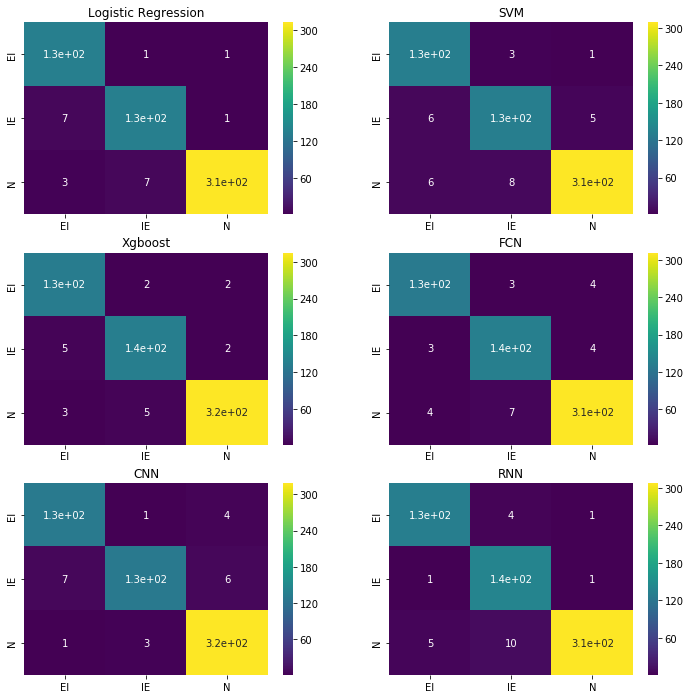

In [98]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12,12))
axs[0][0].set_title("Logistic Regression")
axs[0][1].set_title("SVM")
axs[1][0].set_title("Xgboost")
axs[1][1].set_title("FCN")
axs[2][0].set_title("CNN")
axs[2][1].set_title("RNN")

sns.heatmap(confusion_matrix(y_test_idx, pred_leg), ax=axs[0][0],cmap="viridis", annot=True, xticklabels=ticklabel, yticklabels=ticklabel)
sns.heatmap(confusion_matrix(y_test_idx, pred_svm), ax=axs[0][1],cmap="viridis", annot=True, xticklabels=ticklabel, yticklabels=ticklabel)
sns.heatmap(confusion_matrix(y_test_idx, pred_xgb), ax=axs[1][0],cmap="viridis", annot=True, xticklabels=ticklabel, yticklabels=ticklabel)
sns.heatmap(confusion_matrix(y_test_idx, pred_fcn), ax=axs[1][1],cmap="viridis", annot=True, xticklabels=ticklabel, yticklabels=ticklabel)
sns.heatmap(confusion_matrix(y_test_idx, pred_cnn), ax=axs[2][0],cmap="viridis", annot=True, xticklabels=ticklabel, yticklabels=ticklabel)
sns.heatmap(confusion_matrix(y_test_idx, pred_rnn), ax=axs[2][1],cmap="viridis", annot=True, xticklabels=ticklabel, yticklabels=ticklabel)


- Some models are strong in different classes. ensembling may works.

# Conclusion <a class="anchor" id="4"></a>


## Summary(after many trial...)

## Experiment environment
- `ubuntu 16.04`
- `python 3.67`
- `GTX-1080ti with CUDA9 CUDNN 7.13`
- `library dependency in requirements.txt`

`metric` : accuracy and softmax cross-entropy(tree, neural networks)

## Classical ML Algorithms 
`Logistic Regression` : Fast and poor.

`SVM` : Little bit slow and poor.

`Tree boosting` : Little bit slow(when using a big n_estimators), many tunable parameters.

## Deep Learning Algorithms
`FCN` : Easily Overfitted(even though used L2norm & Dropout)

`CNN` : Relatively fast with many parameters and deep structure.

`RNN` : Slow but strongest. Can handle variable length(not this case with fixed length(60))

## My opinion

It's too small dataset, so that main issue was handling overfitting.(every model can easily get 100% train accuracy)

***Classical Machine Learnings*** are relatively time - space efficient. so parameter tuning and ensembling can make good result. specially small input-label dimension case like this dataset.

***Deep Learning Algorithms*** are relatively time-space inefficient. better performance in more complicated case(expand dimension using embedding works).rnn or padding with positional encoding can handle varialbe length case.